In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Load Paired Training Data**

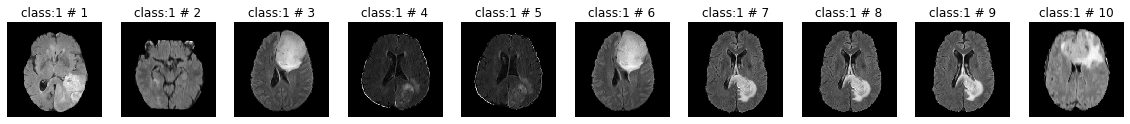

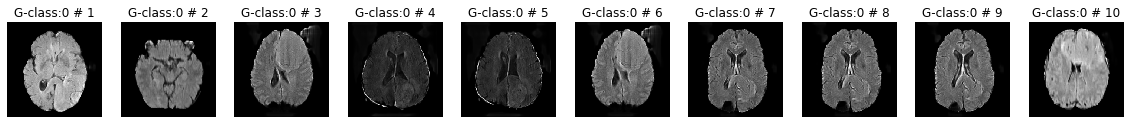

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/content/drive/My Drive/GitHub Repositories')
baseDir = './Research Paper Contribution/Cascaded Model/BRATS Data'

trainDir = os.path.join(baseDir, 'dataset', 'train')
infectedImgs = np.load(os.path.join(trainDir, 'infected_images.npy'), mmap_mode='r')
gennormalImgs = np.load(os.path.join(trainDir, 'generated-normal_images.npy'), mmap_mode='r')

def plotResult(infected, normal):
  plt.figure(1, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('class:1 # {}' .format(i+1))
    plt.imshow(infected[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('G-class:0 # {}' .format(i+1))
    plt.imshow(normal[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()
  plt.close()

plotResult(infectedImgs, gennormalImgs)

**Generator to Generate Mask:**
> The concept is what mask M(x) added to x changes it to y.
>>                               y = x + M(x)
  
**Discriminator to validate the generated class:**



In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
import keras
from keras.layers.advanced_activations import LeakyReLU

img_rows, img_cols, channels = 256, 256, 1
image_shape = (img_rows, img_cols, channels)

def Generator():
  inputs = Input(image_shape)
  
  #Downsampling
  conv1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)   # 64
  conv1 = LeakyReLU(alpha=0.2)(conv1)
  
  conv2 = Conv2D(128, (4, 4), strides=2, padding='same')(conv1)   # 32
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = BatchNormalization(momentum=0.8)(conv2)

  
  conv3 = Conv2D(256, (4, 4), strides=2, padding='same')(conv2)   # 16
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = BatchNormalization(momentum=0.8)(conv3)
  
  conv4 = Conv2D(512, (4, 4), strides=2, padding='same')(conv3)   # 8
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = BatchNormalization(momentum=0.8)(conv4)

  conv5 = Conv2D(512, (4, 4), strides=2, padding='same')(conv4)   # 8
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = BatchNormalization(momentum=0.8)(conv5)
  

  #Upsampling
  Deconv1 = UpSampling2D(size=2)(conv5) # 16
  Deconv1 = Conv2D(512, (4, 4), strides=1, padding='same', activation='relu')(Deconv1)
  Deconv1 = BatchNormalization(momentum=0.8)(Deconv1)
  Deconv1 = Concatenate()([Deconv1, conv4])

  Deconv2 = UpSampling2D(size=2)(Deconv1) # 32
  Deconv2 = Conv2D(512, (4, 4), strides=1, padding='same', activation='relu')(Deconv2)
  Deconv2 = BatchNormalization(momentum=0.8)(Deconv2)
  Deconv2 = Concatenate()([Deconv2, conv3])

  Deconv3 = UpSampling2D(size=2)(Deconv2) # 64
  Deconv3 = Conv2D(512, (4, 4), strides=1, padding='same', activation='relu')(Deconv3)
  Deconv3 = BatchNormalization(momentum=0.8)(Deconv3)
  Deconv3 = Concatenate()([Deconv3, conv2])

  Deconv4 = UpSampling2D(size=2)(Deconv3) # 64
  Deconv4 = Conv2D(512, (4, 4), strides=1, padding='same', activation='relu')(Deconv4)
  Deconv4 = BatchNormalization(momentum=0.8)(Deconv4)
  Deconv4 = Concatenate()([Deconv4, conv1])

  Deconv5 = UpSampling2D(size=(2, 2))(Deconv4)   # 128
  outputs = Conv2D(channels, (4, 4), strides=1, padding='same', activation='tanh')(Deconv5)
  
  return Model(inputs=inputs, outputs=outputs, name='Generator')

def Discriminator():
  inputs = Input(image_shape)
  
  #Downsampling
  conv1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)   # 128
  conv1 = LeakyReLU(alpha=0.2)(conv1)
  
  conv2 = Conv2D(128, (4, 4), strides=2, padding='same')(conv1)   # 64
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = BatchNormalization(momentum=0.8)(conv2)

  conv3 = Conv2D(256, (4, 4), strides=2, padding='same')(conv2)   # 32
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = BatchNormalization(momentum=0.8)(conv3)
  
  conv4 = Conv2D(512, (4, 4), strides=2, padding='same')(conv3)   # 16
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = BatchNormalization(momentum=0.8)(conv4)
  
  conv5 = Conv2D(512, (4, 4), strides=2, padding='same')(conv4)   # 8
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = BatchNormalization(momentum=0.8)(conv5)

  conv6 = Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')(conv5)   # 4
  conv6 = LeakyReLU(alpha=0.2)(conv6)
  conv6 = BatchNormalization(momentum=0.8)(conv6)  
  
  outputs = Conv2D(1, (4, 4), strides=1, padding='same')(conv6)
  
  return Model(inputs=inputs, outputs=outputs, name='Discriminator')

  
optimizer = Adam(0.0002, 0.5) 
D = Discriminator()
print(D.summary())
D.compile(loss='mse',  optimizer=optimizer, metrics=['accuracy'])
D.trainable = False

G = Generator()
print(G.summary())
input_img = Input(image_shape)
mask = G(input_img)
added_img = add([mask, input_img]) 

valid = D(added_img)

combined = Model(inputs = input_img, outputs = [valid, valid])
combined.compile(loss=['mse', 'mae'], loss_weights = [50, 100], optimizer=optimizer)


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 128, 128, 64)      1088      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 256)     

In [0]:
import datetime
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import sys
import numpy as np

epochs=30
batchsize=10
patch = int(img_rows/2**6)
disc_patch = (patch, patch, 1)
start_time = datetime.datetime.now()
batches = int(infectedImgs.shape[0]/batchsize)

# Adversarial loss ground truths
valid = np.ones((batchsize,) + disc_patch)
fake = np.zeros((batchsize,) + disc_patch)


modelDir = os.path.join(baseDir, 'saved models', 'Step 2')
print('Epochs : {} , Batches : {} , Batch size : {}'.format(epochs, batches, batchsize))

for epoch in range(epochs):
  print('Epoch : {}/{}'.format(epoch+1, epochs))
  for batch in range(batches):
    infected = infectedImgs[batch*batchsize : (batch+1)*batchsize]
    normal = gennormalImgs[batch*batchsize : (batch+1)*batchsize]

    masks = G.predict(infected)
    added = normal + masks

    d_loss_real = D.train_on_batch(infected, valid)
    d_loss_fake = D.train_on_batch(added, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    g_loss = combined.train_on_batch(added, [valid, valid]) 

    sys.stdout.write('\r Batch : {0}/{1} , [D-loss : {2:.3f} , D-acc : {3:.2f}%], [G-loss :{4}]'.format(batch+1, batches,
                                                                                                        d_loss[0], d_loss[1]*100, np.mean(g_loss)))
  
  folder = os.path.join(modelDir, 'Epoch_{}'.format(epoch))
  if not os.path.exists(folder):
    os.makedirs(folder)
  G.save(folder+'/G-2-detect-mask.h5')
  plt.figure(1, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Normal # {}' .format(i+1))
    plt.imshow(normal[i, :, :, 0], vmin=-1, vmax=1, cmap='gray')
  plt.figure(2, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Mask # {}' .format(i+1))
    plt.imshow(masks[i, :, :, 0], vmin=-1, vmax=1, cmap='gray')
  plt.figure(3, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Added # {}' .format(i+1))
    plt.imshow(added[i, :, :, 0], vmin=-1, vmax=1, cmap='gray')
  plt.figure(4, figsize=(20,20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Infected # {}' .format(i+1))
    plt.imshow(infected[i, :, :, 0], vmin=-1, vmax=1, cmap='gray')
  plt.show()
  plt.close()
 


**Load the Best Model and Evaluate the Results**

In [0]:
import os
from keras.models import load_model
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import load_img, img_to_array, save_img
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_rows = 256
img_cols = 256
channels = 1

os.chdir('/content/drive/My Drive/GitHub Repositories')
baseDir = './Research Paper Contribution/Cascaded Model/BRATS Data'

modelDir = os.path.join(baseDir, 'saved models', 'Step 2')

G = load_model(os.path.join(modelDir, 'Best Epoch Model', 'G-2-detect-mask.h5'))
print('Model load Successfully.')

dataDir = os.path.join(baseDir, 'dataset', 'valid', 'Images to generate Heatmaps')
Masks = []
infectedImgs = []
names = os.listdir(dataDir)
for infected_img in tqdm(names):
  img = load_img(os.path.join(dataDir, infected_img), color_mode='grayscale')
  img = img_to_array(img)/127.5-1
  img = img.reshape(-1, 256, 256, 1)
  msk = G.predict(img)
  infectedImgs.append(img)
  Masks.append(msk)

infectedImgs = np.asarray(infectedImgs).reshape(-1, img_rows, img_cols, channels)
infectedImgs = 0.5 * infectedImgs + 0.5
Masks = np.asarray(Masks).reshape(-1, img_rows, img_cols, channels)
Masks = 0.5 * Masks + 0.5
Masks = 1 - Masks



def getHeatMap(img, msk):
  image = img
  image = (image*255).astype('uint8')
  mask = msk
  cmap = plt.get_cmap('jet')
  rgba_img = cmap(mask)
  filter_img = np.delete(rgba_img, 3, 2)
  alpha = 0.4
  output = cv2.merge([image, image, image])
  overlay = (filter_img.copy()*255).astype('uint8')
  heatmap = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
  return heatmap

Heatmaps = []
for i in range(Masks.shape[0]):
  heatmap = getHeatMap(infectedImgs[i, :, :, 0], Masks[i, :, :, 0])
  Heatmaps.append(heatmap)
  
Heatmaps = np.stack(Heatmaps)

Model load Successfully.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


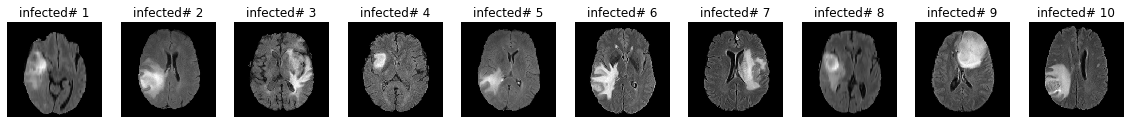

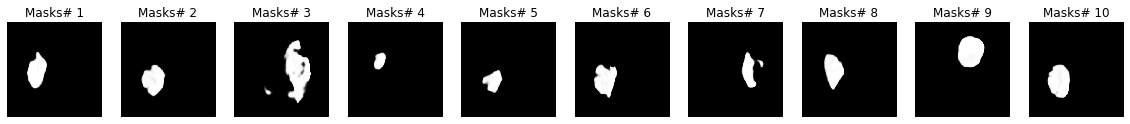

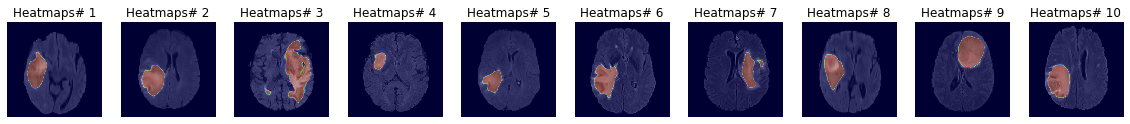

In [0]:
def plotResults(Images, Masks, Heatmaps):
  plt.figure(1, figsize=(20,20))
  for i in range(Images.shape[0]):
    plt.subplot(1, Images.shape[0], i+1).set_title('infected# {}' .format(i+1))
    plt.imshow(Images[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize=(20,20))
  for i in range(Masks.shape[0]):
    plt.subplot(1, Masks.shape[0], i+1).set_title('Masks# {}' .format(i+1))
    plt.imshow(Masks[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(3, figsize=(20,20))
  for i in range(Heatmaps.shape[0]):
    plt.subplot(1, Heatmaps.shape[0], i+1).set_title('Heatmaps# {}' .format(i+1))
    plt.imshow(Heatmaps[i])
    plt.axis('off')
  plt.show()
  plt.close()

plotResults(infectedImgs[:10], Masks[:10], Heatmaps[:10])